In [1]:
import os
import sys
import ast
import cv2
import json
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
sys.path.append('./')
from utils import normalize_image, plot_image, plot_images

In [2]:
# root_dir = '/data/jupiter/datasets/Jupiter_train_v5_11'
# root_dir = '/data/jupiter/datasets/Jupiter_train_v5_11_20230508'
# root_dir = '/data2/jupiter/datasets/Jupiter_train_v6_2'
# root_dir = '/data2/jupiter/datasets/halo_rgb_stereo_train_v6_1'
root_dir = '/data2/jupiter/datasets/halo_rgb_stereo_test_v6_1'
# root_dir = '/data/jupiter/datasets/20230823_labeled_right_images_12k'
# root_dir = '/data/jupiter/li.yu/data/left_and_right_labels_samples'
# root_dir = '/data/jupiter/li.yu/data/Jupiter_2022_Dust_Humans_Unfiltered_partiallabeled'
# csv = os.path.join(root_dir, '642ba9506651c8d5688518e0_master_annotations_ppcutnpastecolumns.csv')
csv = os.path.join(root_dir, 'master_annotations_dedup.csv')
# csv = os.path.join(root_dir, 'v61base_epoch0_5_30_focal05_master_annotations.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
df = pd.read_csv(csv, converters=converters)
df.shape

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (1,2,23,80,91,92,93,94,95,97,98,100,101,102,103,104,105,106,107,108,118,151,155,156,161,172,175,197,198,200,201,202,203,228,229,230,237,238,250,252,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,273,277,278,279,282,286) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(50864, 323)

In [15]:
# load cutnpaste columns
# df2 = pd.read_parquet('/data2/jupiter/datasets/Jupiter_train_v6_2/cache/cutnpaste_961706335.parquet')
df2 = pd.read_csv('/data2/jupiter/datasets/halo_rgb_stereo_train_v6_1/cache/cutnpaste_1553242183.csv')
df2.shape

(147222, 344)

In [16]:
set(df2.columns) - set(df.columns)

{'brightness',
 'color_transfer_npz_save_path',
 'humans_max_col',
 'humans_max_row',
 'humans_min_col',
 'humans_min_row',
 'humans_pixel_count',
 'is_humans_present_in_annotations',
 'is_laying_down_human',
 'is_multi_human',
 'is_standing_human',
 'is_tractors_or_vehicles_present_in_annotations',
 'label_counts',
 'occluded_humans',
 'tractors_or_vehicles_max_col',
 'tractors_or_vehicles_max_row',
 'tractors_or_vehicles_min_col',
 'tractors_or_vehicles_min_row',
 'tractors_or_vehicles_pixel_count'}

In [4]:
df2['is_humans_present_in_annotations'] = df2['humans_pixel_count'] > 0
df2['is_tractors_or_vehicles_present_in_annotations'] = df2['tractors_or_vehicles_pixel_count'] > 0
print(df2.columns)
common_columns = ['brightness', 'label_counts', 
       'humans_pixel_count', 'humans_max_row', 'humans_min_row',
       'humans_max_col', 'humans_min_col', 'is_multi_human',
       'is_standing_human', 'is_laying_down_human', 'occluded_humans',
       'tractors_or_vehicles_pixel_count', 'tractors_or_vehicles_max_row',
       'tractors_or_vehicles_min_row', 'tractors_or_vehicles_max_col',
       'tractors_or_vehicles_min_col',
       'is_humans_present_in_annotations',
       'is_tractors_or_vehicles_present_in_annotations']
common_columns = set(common_columns).intersection(list(df.columns))
# drop columns in df
df.drop(common_columns, axis=1, inplace=True)
print(df.shape)
df1 = df.merge(df2, on='unique_id')
print(df1.shape)

Index(['brightness', 'label_counts', 'Airborne-debris', 'Driveable',
       'humans_pixel_count', 'humans_max_row', 'humans_min_row',
       'humans_max_col', 'humans_min_col', 'is_multi_human',
       'is_standing_human', 'is_laying_down_human', 'occluded_humans',
       'tractors_or_vehicles_pixel_count', 'tractors_or_vehicles_max_row',
       'tractors_or_vehicles_min_row', 'tractors_or_vehicles_max_col',
       'tractors_or_vehicles_min_col', 'unique_id',
       'is_humans_present_in_annotations',
       'is_tractors_or_vehicles_present_in_annotations'],
      dtype='object')
(318874, 416)
(318874, 436)


In [13]:
# update stereo_pipeline_npz_save_path with clean depth
df2 = pd.read_csv('/data2/jupiter/datasets/Jupiter_train_v6_2/master_annotations_20231019_clean.csv')
print(df2.shape)
df1.drop(columns=['stereo_pipeline_npz_save_path'], axis=1, inplace=True)
print(df1.shape)
df1 = df1.merge(df2[['id', 'stereo_pipeline_npz_save_path']], on='id')
print(df1.shape)
df1.to_csv('/data2/jupiter/datasets/Jupiter_train_v6_2/master_annotations_20231019_clean_fl05.csv', index=False)

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (7,8,40,59,60,61,62,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,81,82,83,84,85,86,87,88,89,90,91,110,111,112,113,115,116,117,118,119,120,121,122,123,124,125,144,145,146,147,149,150,151,152,153,154,155,156,157,158,159,161,162,163,164,166,167,168,169,170,171,172,173,174,175,176,178,179,180,181,183,184,185,186,187,188,189,190,191,192,193,224,226,228,231,248,252,255,256,262,263,264,268,309,320,325,327,328,338,339,347,355,371,372,374,375,377,378) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(321638, 425)
(318874, 435)
(318874, 436)


In [4]:
df1 = df.copy()
# df2 = df.copy()
print(df1.shape, df2.shape)
print(set(df1.columns) - set(df2.columns))
print(set(df2.columns) - set(df1.columns))

(318874, 434) (321638, 19)
{'artifacts_content_hash', 'artifact_raw_0_data_category', 'hdr_library', 'operation_time', 'artifact_debayeredrgb_0_data_category', 'artifact_debayeredrgb_0_content_hash', 'label_map', 'annotation_pixelwise_0_vendor_metadata', 'jupiter_simpleui_hash', 'dummy_gps', 'artifact_rectified_0_image', 'mime_type', 'artifact_segconf_0_image', 'jupiter_libs_intel__jupiter_utils', 'updated_at', 'water_management', 'geohash', 'hdr_algo', 'artifact_detections_0_updated_at', 'artifact_rgb_0_id', 'annotation_pixelwise_0_aletheia_id', 'libsgm', 'annotation_pixelwise_0_id', 'annotation_pixelwise_0_label_map', 'artifact_detections_0_is_archived', 'artifact_debayeredrgb_0_s3_bucket', 'rectified_stereo_output_width', 'annotation_pixelwise_0_audit_by', 'artifact_detections_0_created_at', 'annotation_pixelwise_0_created_at', 'artifact_segmap_0_web_s3_key', 'location_human_tagged', 'plug_repurposed', 'artifact_rectified_0__id', 'image_id', 'date', 'receiving_human_tagged', 'grower

In [22]:
df1.iloc[0].stereo_pipeline_npz_save_path, df2.iloc[0].stereo_pipeline_npz_save_path

('processed_20231019_clean/images/614d0eb90f7787d7ba7d1e43/stereo_output.npz',
 'processed_20231019_clean/images/614d0eb90f7787d7ba7d1e43/stereo_output.npz')

In [15]:
# df2['stereo_pipeline_npz_save_path'] = df2['stereo_pipeline_npz_save_path'].apply(lambda p: p[43:])
# df2['rectified_label_save_path'] = df2['rectified_label_save_path'].apply(lambda p: p[43:])
# df2 = df2.drop('color_transfer_npz_save_path', axis=1)
# df2.iloc[0].stereo_pipeline_npz_save_path, df2.iloc[0].rectified_label_save_path

('processed/images/614d0eb90f7787d7ba7d1e43/stereo_output.npz',
 'processed/images/614d0eb90f7787d7ba7d1e43/rectification_output_61dd087a50a352ea47e1e4b4.npz')

In [3]:
label_map_file = '/home/li.yu/code/JupiterCVML/europa/base/src/europa/dl/config/label_maps/seven_class_train.csv'
label_df = pd.read_csv(label_map_file)
stop_classes = label_df[label_df.train_id.isin([1, 3, 5, 6])].class_name.to_list()
print(len(stop_classes), stop_classes)

11 ['Utility pole', 'Trees', 'Immovable Objects', 'Buildings', 'Tractors or Vehicles', 'Humans', 'Animals', 'Birds', 'Tile-Inlet', 'Object Lights', 'Flooded Area']


In [4]:
negative_ids, negative_ids_depth30 = [], []
threshold = 72
for i, row in tqdm(df.iterrows(), total=len(df)):
    # get depth
    data_path = os.path.join(root_dir, row.stereo_pipeline_npz_save_path)
    stereo_data = np.load(data_path)
    depth = stereo_data['point_cloud'][:,:,-1] / 100.0
    
    # get label
    label_map = row.label_map
    label_path = os.path.join(root_dir, row.rectified_label_save_path)
    label = np.load(label_path)['left'][:,:,0]
    labels, counts = np.unique(label, return_counts=True)
    label_counts = {label_map[str(i)]: c for i,c in zip(labels, counts) if i != 0}
    stop_class_count = sum(label_counts.get(c, 0) for c in stop_classes)
    if stop_class_count < threshold:
        negative_ids.append(row.unique_id)
    label_depth_30 = label[depth <= 0.3]
    labels, counts = np.unique(label_depth_30, return_counts=True)
    label_counts = {label_map[str(i)]: c for i,c in zip(labels, counts) if i != 0}
    stop_class_count = sum(label_counts.get(c, 0) for c in stop_classes)
    if stop_class_count < threshold:
        negative_ids_depth30.append(row.unique_id)
    # break
print(len(negative_ids), len(negative_ids_depth30))
nega_df = pd.DataFrame(data={'unique_id': negative_ids})
nega_d30_df = pd.DataFrame(data={'unique_id': negative_ids_depth30})
nega_df.to_csv('/data2/jupiter/datasets/halo_rgb_stereo_test_v6_1/productivity_ids.csv', index=False)
nega_d30_df.to_csv('/data2/jupiter/datasets/halo_rgb_stereo_test_v6_1/productivity_ids_within30m.csv', index=False)

100%|██████████| 50864/50864 [35:28<00:00, 23.90it/s]


7063 34996


In [8]:
df[(~df.unique_id.isin(negative_ids)) & (df.unique_id.isin(negative_ids_depth30))].shape

(27933, 323)

652dae1860a0df028b90bd0f T13


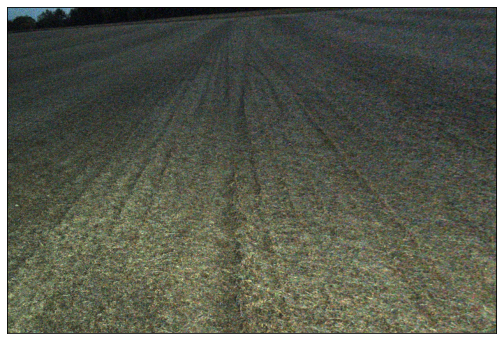

652dae1860a0df028b90bd0f_T13_T15 [2 6 7] ['Untilled field', 'Trees', 'Sky']


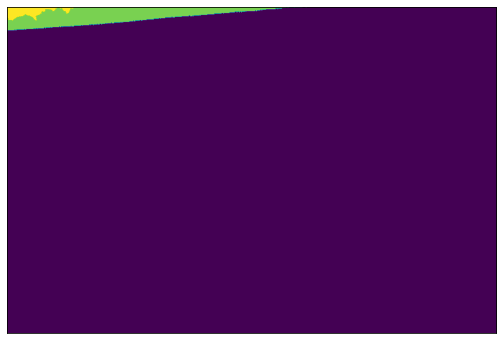

64dbc461b63dab5cffe618cf T02


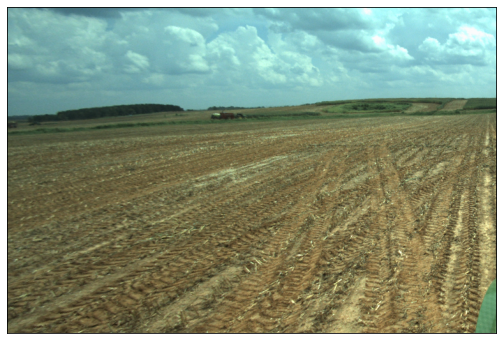

64dbc461b63dab5cffe618cf_T02_T04 [ 2  4  5  6  7  8 10 19] ['Untilled field', 'Roadside Buffer', 'Utility pole', 'Trees', 'Sky', 'Immovable Objects', 'Tractors or Vehicles', 'Ego Tractor']


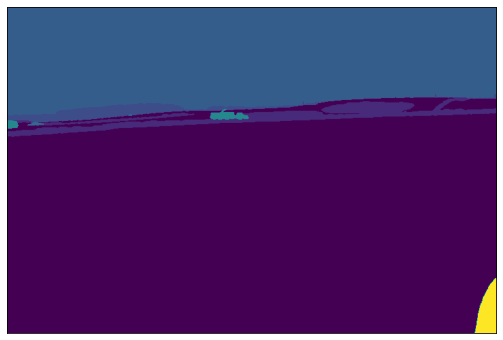

In [12]:
# sub_df = df2[df2.camera_pod == 'implement_pod'].sample(5)
sub_df = df[(~df.unique_id.isin(negative_ids)) & (df.unique_id.isin(negative_ids_depth30))].sample(2)
# sub_df = df[df.unique_id == '64d6542284dac3a508c73ae0_T14_T15']
# sub_df = df2[df2.human_aspect_ratio > 1].sample(2)
# sub_df = df[df.id.isin(['6441f343fb7e8d35a3da7e9c', '6441f9199b12538afbfcc044'])]
show_image, show_label = True, True
show_debayered_rgb, show_raw_label = False, False
show_pred_result = False
dataset = ''
for i, row in sub_df.iterrows():
    # print(row.id, row.gt_dust_ratio, row.pred_dust_ratio)
    print(row.id, row.camera_location)
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, True)
        plot_image(img_norm)

    if show_debayered_rgb:
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        lbl = np.load(label_path)['left']
        labels = np.unique(lbl)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(lbl))
        plot_image(lbl)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        plot_image(label)

    if show_pred_result:
        result_path = os.path.join(pred_dir, 'output_visualization', row.id+'.png')
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB)
            plot_image(res_img, figsize=(20, 6))